In [1]:
!pip install -q torch_snippets
from torch_snippets import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.MNIST(root='MNIST/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='MNIST/', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.9/172.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.4 MB/s eta 0:00:0

100%|██████████| 9912422/9912422 [00:00<00:00, 158347468.18it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111337953.88it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 35687003.13it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4266635.78it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



In [2]:
class VAE(nn.Module):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
    super(VAE, self).__init__()
    self.d1 = nn.Linear(x_dim, h_dim1)
    self.d2 = nn.Linear(h_dim1, h_dim2)
    self.d31 = nn.Linear(h_dim2, z_dim)
    self.d32 = nn.Linear(h_dim2, z_dim)
    self.d4 = nn.Linear(z_dim, h_dim2)
    self.d5 = nn.Linear(h_dim2, h_dim1)
    self.d6 = nn.Linear(h_dim1, x_dim)
  def encoder(self, x):
    h = F.relu(self.d1(x))
    h = F.relu(self.d2(h))
    return self.d31(h), self.d32(h)
  def sampling(self, mean, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mean)
  def decoder(self, z):
    h = F.relu(self.d4(z))
    h = F.relu(self.d5(h))
    return F.sigmoid(self.d6(h))
  def forward(self, x):
    mean, log_var = self.encoder(x.view(-1, 784))
    z = self.sampling(mean, log_var)
    return self.decoder(z), mean, log_var

In [3]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [4]:
def loss_function(recon_x, x, mean, log_var):
  RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
  KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
  return RECON + KLD, RECON, KLD

In [5]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

EPOCH: 1.000  train_recon: 2671.557  train_kld: 255.880  val_recon: 1935.198  val_kld: 443.666  train_loss: 2927.437  val_mean: -0.005  val_loss: 2378.864  val_log_var: -0.269  train_mean: -0.000  train_log_var: -0.155  (16.60s - 149.44s remaining)


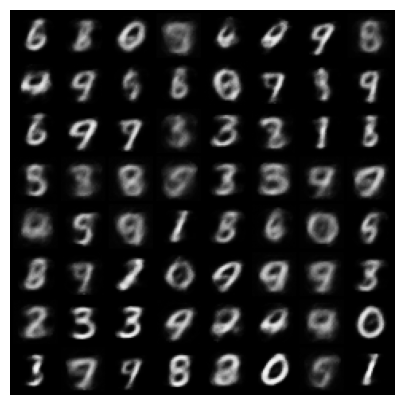

EPOCH: 2.000  train_recon: 1719.230  train_kld: 492.887  val_recon: 1553.600  val_kld: 525.035  train_loss: 2212.117  val_mean: 0.006  val_loss: 2078.635  val_log_var: -0.321  train_mean: -0.000  train_log_var: -0.300  (28.50s - 113.99s remaining)


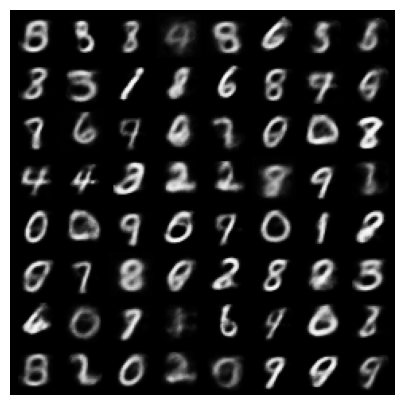

EPOCH: 3.000  train_recon: 1499.744  train_kld: 553.888  val_recon: 1454.132  val_kld: 550.926  train_loss: 2053.632  val_mean: 0.001  val_loss: 2005.058  val_log_var: -0.340  train_mean: 0.001  train_log_var: -0.341  (44.03s - 102.74s remaining)


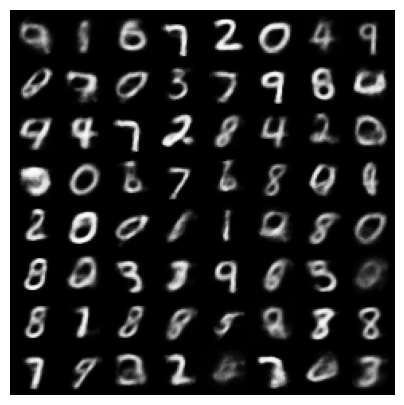

EPOCH: 4.000  train_recon: 1415.031  train_kld: 574.864  val_recon: 1354.904  val_kld: 598.393  train_loss: 1989.895  val_mean: -0.001  val_loss: 1953.297  val_log_var: -0.377  train_mean: 0.000  train_log_var: -0.356  (56.33s - 84.50s remaining)


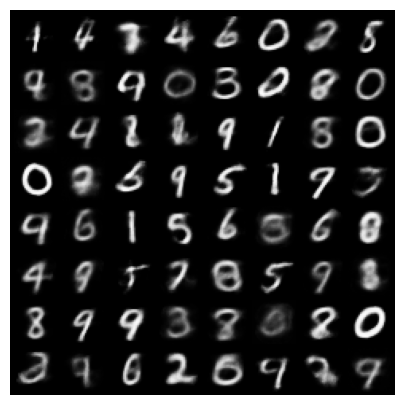

EPOCH: 5.000  train_recon: 1360.252  train_kld: 590.250  val_recon: 1333.161  val_kld: 594.919  train_loss: 1950.501  val_mean: 0.005  val_loss: 1928.080  val_log_var: -0.366  train_mean: 0.000  train_log_var: -0.366  (68.41s - 68.41s remaining)


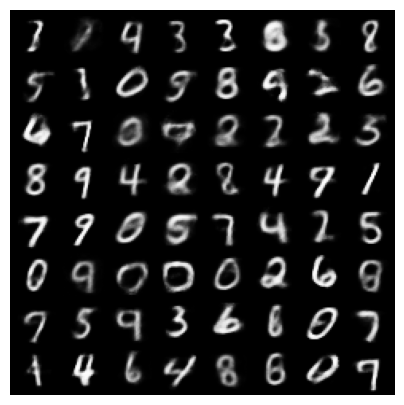

EPOCH: 6.000  train_recon: 1319.011  train_kld: 603.200  val_recon: 1294.301  val_kld: 600.313  train_loss: 1922.211  val_mean: 0.005  val_loss: 1894.615  val_log_var: -0.369  train_mean: 0.000  train_log_var: -0.374  (80.89s - 53.93s remaining)


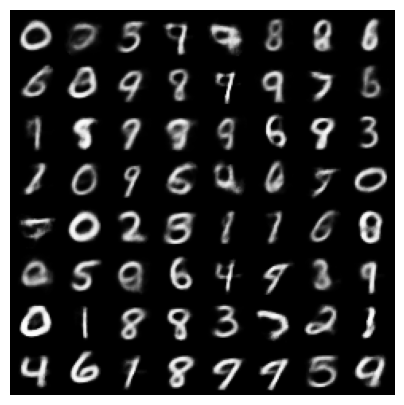

EPOCH: 7.000  train_recon: 1288.835  train_kld: 611.663  val_recon: 1262.154  val_kld: 619.298  train_loss: 1900.497  val_mean: 0.004  val_loss: 1881.452  val_log_var: -0.384  train_mean: 0.000  train_log_var: -0.381  (93.57s - 40.10s remaining)


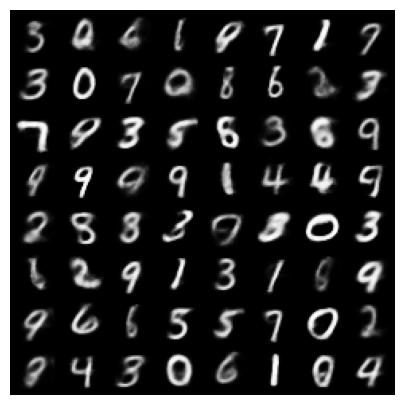

EPOCH: 8.000  train_recon: 1264.079  train_kld: 618.087  val_recon: 1232.272  val_kld: 629.940  train_loss: 1882.166  val_mean: 0.002  val_loss: 1862.212  val_log_var: -0.392  train_mean: 0.000  train_log_var: -0.385  (106.19s - 26.55s remaining)


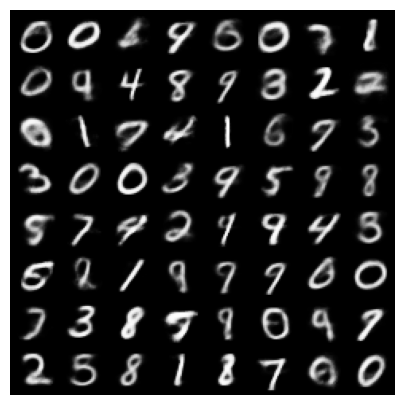

EPOCH: 9.000  train_recon: 1242.702  train_kld: 624.024  val_recon: 1226.351  val_kld: 619.515  train_loss: 1866.727  val_mean: 0.005  val_loss: 1845.866  val_log_var: -0.388  train_mean: 0.000  train_log_var: -0.389  (118.97s - 13.22s remaining)


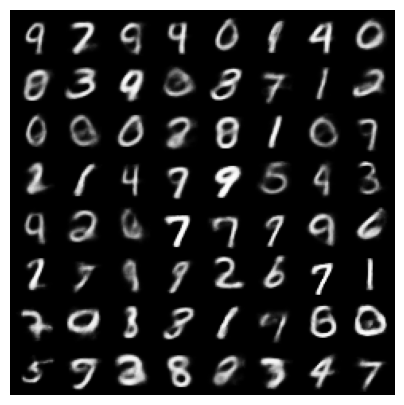

EPOCH: 10.000  train_recon: 1227.632  train_kld: 629.931  val_recon: 1208.461  val_kld: 637.444  train_loss: 1857.563  val_mean: -0.001  val_loss: 1845.906  val_log_var: -0.399  train_mean: 0.000  train_log_var: -0.393  (131.25s - 0.00s remaining)


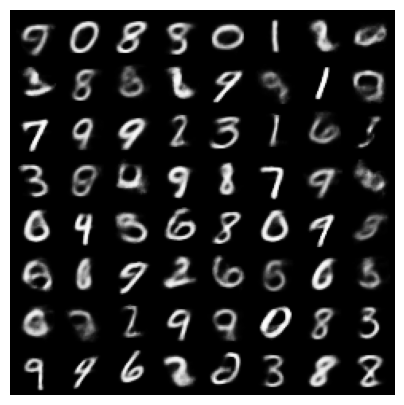

In [6]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')

    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')

    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)

100%|██████████| 111/111 [00:00<00:00, 433.32it/s]


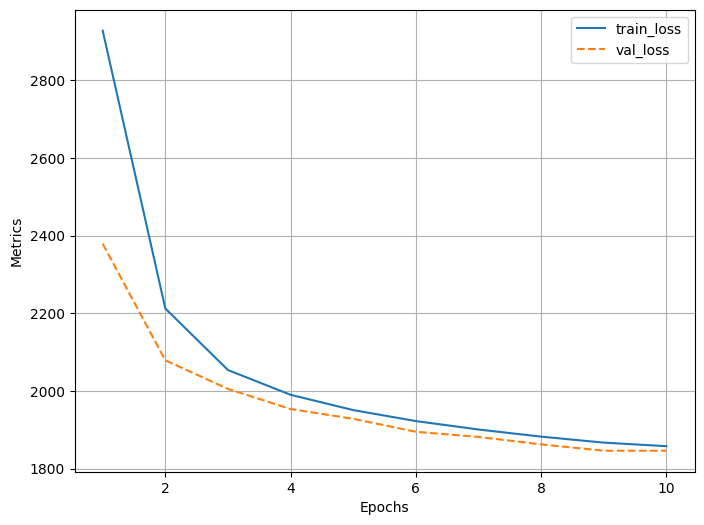

In [7]:
log.plot_epochs(['train_loss','val_loss'])

---